# In this notebook we plan the fix-priority path for two agents on the hybrid graph and animate the result.

In [2]:
import sys
sys.path.append('../')
from panav.env import NavigationEnv, Box2DRegion, box_2d_center
from panav.hybrid import HybridGraph
from panav.viz import draw_env,draw_hybrid

import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [6]:
from panav.PBS.PBS_hybrid_SIPP import PBS_hybrid_SIPP
(g_joint_plan, c_joint_plan),cost = PBS_hybrid_SIPP(HG)

/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/cvxpy/problems/problem.py:1391: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)


In [8]:
from panav.viz import animation,interpolate_positions

from IPython.display import HTML, display
interp_dt = 0.1

pos = []
for cp in c_joint_plan:
    _,xs = interpolate_positions(*cp,interp_dt)
    pos.append(xs)

anim = animation(env, pos, bloating_r, dt = interp_dt / 4)
# display(HTML(anim.to_jshtml()))
anim.save("../Figures/HybridPBS_exec.gif")
plt.close()   # Avoid plotting an extra figure.

## Double tunnel

In [6]:


# 2D navigation environment

start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

top, bottom = 9,-9
start_x_offset = 7
goal_x_offset = 9
N = 4

start_locs = np.vstack([
np.vstack([np.ones(N)*start_x_offset,np.linspace(top,bottom, N)]).T,
np.vstack([np.ones(N)*(-start_x_offset),np.linspace(top,bottom, N)]).T])

goal_locs = np.vstack([
np.vstack([np.ones(N)*(-goal_x_offset),np.linspace(bottom,top, N)]).T,
np.vstack([np.ones(N)*goal_x_offset,np.linspace(bottom,top, N)]).T])


starts = [box_2d_center(s,start_box_side) for s in start_locs]
goals = [box_2d_center(g,goal_box_side) for g in goal_locs]
limits = [(-10.0,10.0),(-10.0,10.0)]

O1 = Box2DRegion((-2.5,2.5),(0.5,10))
O2 = Box2DRegion((-2.5,2.5),(-3,-1.0))
O3 = Box2DRegion((-2.5,2.5),(-10.0,-4.0))
env = NavigationEnv(limits,[O1,O2,O3],starts,goals)


# Construct the hybrid graph representation of the environment
bloating_r = 0.5 


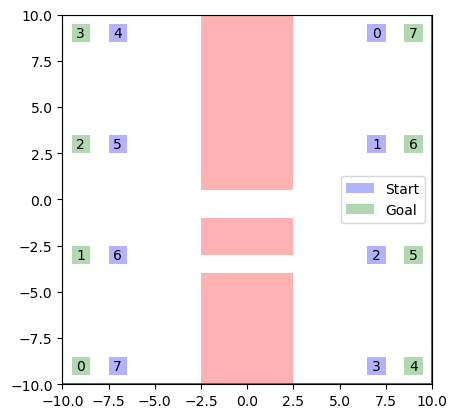

In [9]:
# Construct the hybrid graph representation of the environment
ax = plt.gca()
draw_env(env,[],ax,show_agent_ID=True)
plt.show()    

In [10]:
import cvxpy as cp

In [52]:
H.shape

(4, 6)

In [103]:
def shortest_path(env,start,goal, K=2,d=2):
    M = 100 * np.max(np.abs(env.limits))

    x = cp.Variable((d, K+2))

    constraints = []

    # Start and goal constraints
    constraints+=[x[:,0] == start, x[:,-1] ==  goal]

    # Boundary constraints
    constraints.append(x <= np.array(env.limits)[:,-1].reshape(-1,1) - bloating_r)
    constraints.append(x >= np.array(env.limits)[:,0].reshape(-1,1) + bloating_r)

    # Static obstacle constraints
    obs = env.obstacles
    for O in obs:
        A, b= O.A,O.b

        H = A @ x-(b+ np.linalg.norm(A,axis=1) * bloating_r).reshape(-1,1) # Bloating radius

        alpha = cp.Variable((H.shape[0],H.shape[1]-1),boolean=True)
        
        constraints.append(H[:,1:] + M * (1-alpha)>=0)
        constraints.append(H[:,:-1] + M * (1-alpha)>=0)
        
        constraints.append(cp.sum(alpha,axis = 0)>=1)
        
    obj_func = cp.sum([cp.norm(x[:,i]-x[:,i+1]) for i in range(x.shape[1]-1)])
    prob = cp.Problem(cp.Minimize(obj_func),constraints)
    val = prob.solve(solver='GUROBI') # The Gurobi solver proves to be more accurate and also faster.
    return x.value, val


In [104]:
start = np.array(list(env.starts[0].centroid().coords)[0])
goal = np.array(list(env.goals[0].centroid().coords)[0])

K = 2
d = 2 

path, val = shortest_path(env, start, goal, K,d)

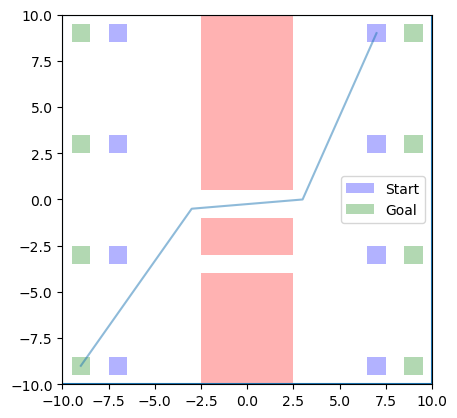

In [105]:
ax = plt.gca()
draw_env(env,[path], ax)
plt.show()    
